In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

## Visualizing Airbnb Barcelona Prices
The dataset is taken from kaggle.com : https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities. 
The dataset chosen is an Airbnb data from european cities. This project looks only at barcelona weekdays and weekends to determine what affects the price of an Airbnb in barcelona. Airbnb is a convenient place for travellers to stay and for residents to earn extra revenue from their property. There are many listings with low and high prices, but which aspect is important to determine the price of an Airbnb?
This project is inspired by Airbnb Data Science project : https://mohamedirfansh.github.io/Airbnb-Data-Science-Project/.

In [109]:
data = pd.concat(map(pd.read_csv, ['barcelona_weekdays.csv', 'barcelona_weekends.csv']), ignore_index=True) # combining the csv
df = data.iloc[: , 1:] # delete the first column
print(df.shape)
df

(2833, 19)


,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,474.317499,Entire home/apt,False,False,4.0,False,0,1,10.0,91.0,1,1.111996,0.630491,526.469420,17.942927,915.587083,20.154890,2.17556,41.39624
1,169.897829,Private room,False,True,2.0,True,1,0,10.0,88.0,1,1.751839,0.124017,320.127526,10.910462,794.277350,17.484489,2.14906,41.38714
2,161.984779,Private room,False,True,4.0,False,0,1,9.0,88.0,1,1.670493,0.080322,344.073936,11.726595,840.673617,18.505814,2.15357,41.37859
3,367.956804,Entire home/apt,False,False,3.0,False,0,1,10.0,91.0,1,1.475847,0.093107,400.057449,13.634603,946.589884,20.837357,2.16839,41.37390
4,196.895292,Private room,False,True,3.0,False,1,0,9.0,91.0,1,1.855452,0.272486,346.042245,11.793678,792.296039,17.440874,2.15238,41.37699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,327.460609,Private room,False,True,2.0,True,0,0,9.0,96.0,1,2.608873,0.932342,271.642736,10.488440,537.512628,11.807347,2.19672,41.39929
2829,242.977169,Private room,False,True,2.0,False,0,0,9.0,80.0,0,1.859134,0.555944,343.045595,13.245387,679.561854,14.927691,2.19099,41.39269
2830,138.943841,Private room,False,True,2.0,False,0,0,10.0,96.0,2,2.670450,0.968673,266.091811,10.274112,534.080063,11.731945,2.19738,41.39954
2831,185.258454,Private room,False,True,2.0,False,0,0,2.0,60.0,1,2.266090,0.387429,290.526738,11.217573,627.521382,13.784536,2.19679,41.39029


In [110]:
# Look for unique values of the categorical columns
print(df["room_type"].unique())
# renaming biz column to business
df = df.rename(columns={"biz": "business"})
# dropping attr_index, attr_index_norm, rest_index, and rest_index_norm since no description of the column name can be found
df = df.drop(['attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm'], axis=1)

['Entire home/apt' 'Private room' 'Shared room']


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     2833 non-null   float64
 1   room_type                   2833 non-null   object 
 2   room_shared                 2833 non-null   bool   
 3   room_private                2833 non-null   bool   
 4   person_capacity             2833 non-null   float64
 5   host_is_superhost           2833 non-null   bool   
 6   multi                       2833 non-null   int64  
 7   business                    2833 non-null   int64  
 8   cleanliness_rating          2833 non-null   float64
 9   guest_satisfaction_overall  2833 non-null   float64
 10  bedrooms                    2833 non-null   int64  
 11  dist                        2833 non-null   float64
 12  metro_dist                  2833 non-null   float64
 13  lng                         2833 

### Finding Outliers

In [112]:
df.describe()

,realSum,person_capacity,multi,business,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat
count,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,293.753706,2.616661,0.385104,0.325450,9.291564,91.109072,1.161313,2.116982,0.441248,2.169379,41.393495
std,355.467888,1.153124,0.486706,0.468625,1.014577,8.607153,0.517108,1.377859,0.284540,0.019545,0.016138
min,69.588289,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.095828,0.012994,2.093470,41.349540
25%,160.821095,2.000000,0.000000,0.000000,9.000000,88.000000,1.000000,1.070443,0.256139,2.156640,41.381180
50%,208.299393,2.000000,0.000000,0.000000,10.000000,93.000000,1.000000,1.732003,0.376994,2.170960,41.390390
75%,329.787977,3.000000,1.000000,1.000000,10.000000,97.000000,1.000000,2.967922,0.555944,2.179730,41.404260
max,6943.700980,6.000000,1.000000,1.000000,10.000000,100.000000,6.000000,8.443967,4.039111,2.225520,41.463080


#### Dealing with outliers

- realSum has max of 6943.7, but the mean is only 293.75 with std of 355. The range of the prices are too large.

To deal with the outlier, we can look into the price per person. The bedroom column has a minimum of zero, so we are unable to use the column.

In [113]:
df["price_per_person"] = df["realSum"]/df["person_capacity"]
df.describe()

,realSum,person_capacity,multi,business,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,price_per_person
count,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,293.753706,2.616661,0.385104,0.325450,9.291564,91.109072,1.161313,2.116982,0.441248,2.169379,41.393495,112.139277
std,355.467888,1.153124,0.486706,0.468625,1.014577,8.607153,0.517108,1.377859,0.284540,0.019545,0.016138,148.733425
min,69.588289,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.095828,0.012994,2.093470,41.349540,20.248097
25%,160.821095,2.000000,0.000000,0.000000,9.000000,88.000000,1.000000,1.070443,0.256139,2.156640,41.381180,73.273287
50%,208.299393,2.000000,0.000000,0.000000,10.000000,93.000000,1.000000,1.732003,0.376994,2.170960,41.390390,94.258384
75%,329.787977,3.000000,1.000000,1.000000,10.000000,97.000000,1.000000,2.967922,0.555944,2.179730,41.404260,122.361347
max,6943.700980,6.000000,1.000000,1.000000,10.000000,100.000000,6.000000,8.443967,4.039111,2.225520,41.463080,3471.850490


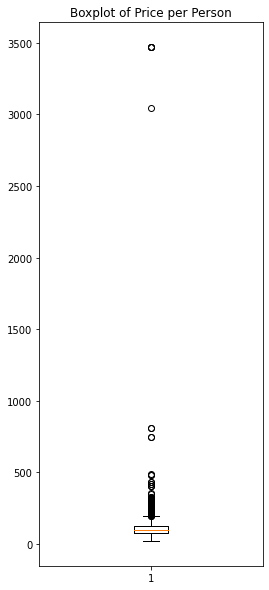

In [114]:
# Visualize outliers for price per bedroom
plt.figure(figsize=(4, 10))
plt.boxplot(df['price_per_person'])
plt.title('Boxplot of Price per Person')
plt.show()

In [117]:
Q1 = df['price_per_person'].quantile(0.25)
Q3 = df['price_per_person'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
print(threshold)

195.99343682360882


In [118]:
row = df.loc[df['price_per_person'] >= 196].index
df = df.drop(row)
print(df.shape)

(2683, 16)


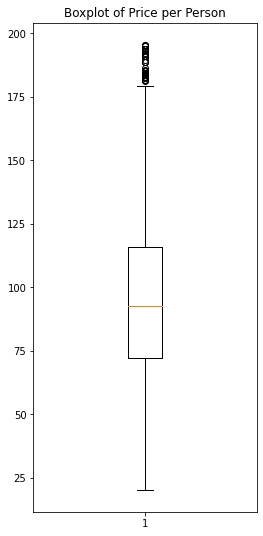

In [119]:
# Visualize outliers for price per bedroom
plt.figure(figsize=(4, 9))
plt.boxplot(df['price_per_person'])
plt.title('Boxplot of Price per Person')
plt.show()

Previously, we have 2833 rows so we removed 150 outliers.

In [120]:
df = df.drop(columns=['price_per_person'])

### Dataset Explanation

#### Columns of the dataset:
- realSum - the total price of the listing (Numeric)
- room_type - the type of room being offered (Categorical : 'Entire home/apt' 'Private room' 'Shared room')
- room_shared - Whether the room is shared or not (Boolean)
- room_private - Whether the room is private or not (Boolean)
- person_capacity - the maximum number of people that can stay in the room (Numeric)
- host_is_superhost - Whether the host is a superhost or not (Boolean)
- multi - whether the listing have multiple rooms (Boolean)
- business - Whether the listing is for business purposes or not (Boolean)
- cleanliness_rating - The cleanliness rating of the listing (Numeric)
- guest_satisfaction_overall - The overall guest satisfaction rating of the listing (Numeric)
- bedrooms - The number of bedrooms in the listing (Numeric)
- dist - The distance from the city centre (Numeric)
- metro_dist - The distance from the nearest metro station (Numeric)
- lng - The longitude of the listing (Numeric)
- lat - The latitude of the listing (Numeric)

#### Other info:
There are 2833 rows in the dataset with 15 columns with 19 rows dropped, so there are 2814 rows in the dataset for analysis. There are no null values in the dataset, so imputation is not needed.

### Analyzing the listings based on room types

[Text(0.5, 0, 'count'),
 Text(0, 0.5, 'room type'),
 Text(0.5, 1.0, 'room_type histogram')]

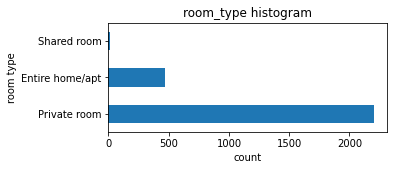

In [122]:
df["room_type"].value_counts().plot.barh(figsize=(5,2)).set(
    xlabel="count", ylabel="room type", title="room_type histogram"
)

Most of the listings are private room and it is four times more frequent than the entire home/apt. Shared room is the least of room_type available.

[Text(0.5, 0, 'person_capacity'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'person capacity count histogram')]

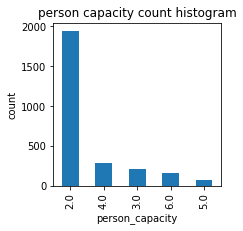

In [123]:
df["person_capacity"].value_counts().plot.bar(figsize=(3,3)).set(
    xlabel="person_capacity", ylabel="count", title="person capacity count histogram"
)

Two person capacity has the most availability, followed by four person capacity. It is surprising that there are limited choices for more than two people.

### Analyzing the prices for the different room and person capacity.

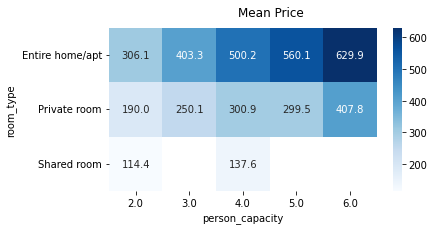

In [124]:
plt.figure(figsize=(6, 3))
df_pivot = df.pivot_table(values='realSum', index='room_type', columns='person_capacity', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt='.1f', cmap='Blues')
plt.suptitle('Mean Price')
plt.xlabel('person_capacity')
plt.ylabel('room_type')
plt.show()

It is to be expected that shared room is the cheapest especially if it has a 2 person capacity, and the second cheapest is a shared room with 137.6 with a 4 person capacity. Thus, a shared room is the cheapest. The most expensive is an entire home/apartment for a two person capacity. From the trend of the private room type, more person capacity is more expensive. However, this trend does not apply to the entire home/apartment room type. A two person capacity is more expensive than a six person capacity, but after three person capacity, the more people in the room type, the more expensive it is. This may be because the host of the Airbnb believe that privacy will make people pay more. Then, we can look into customer's satisfaction with room_type and person_capacity.

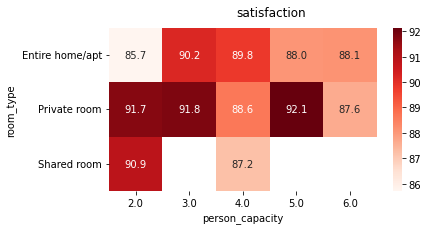

In [125]:
plt.figure(figsize=(6, 3))
df_pivot = df.pivot_table(values='guest_satisfaction_overall', index='room_type', columns='person_capacity', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt='.1f', cmap='Reds')
plt.suptitle('satisfaction')
plt.xlabel('person_capacity')
plt.ylabel('room_type')
plt.show()

The previous suggestion that privacy will create more satisfaction doesn't seem to apply. The room types or the person capacity doesn't affect the satisfaction of the guests. There might be other reason that affects the guests's satisfaction more.

### Analyzing the price for geographical location in Barcelona

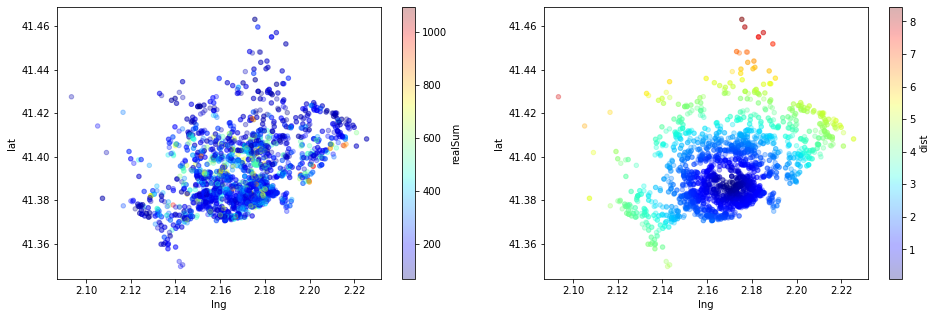

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

df.plot(kind="scatter", x="lng", y="lat", c="realSum", cmap=plt.get_cmap("jet"), colorbar=True, alpha=0.3, ax=axes[0])
df.plot(kind="scatter", x="lng", y="lat", c="dist", cmap=plt.get_cmap("jet"), colorbar=True, alpha=0.3, ax=axes[1])
plt.show()

From the graph above, the further it is from the city center, the cheaper it gets. It is expected that the price of Airbnb is cheaper in places far from the city center because house/apartment prices are more expensive in the city center. The most expensive Airbnb is concentrated in the city center while other less expensive place is still arround the city center. Although we can see some expensive place far from the city center, we can see that the city center are inclined to be expensive.

### Correlation

<AxesSubplot:>

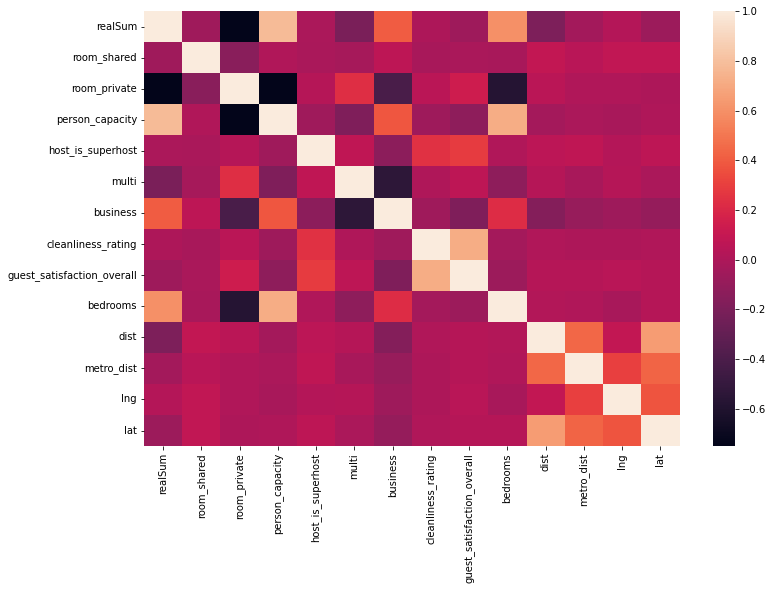

In [127]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr())

In [128]:
# Select columns where there are more than 0.3 correlations with realSum

matrix = df.corr()
price = matrix['realSum']
selected_columns = price[price > 0].index.tolist()
selected_columns.remove('realSum')
print(selected_columns)

['person_capacity', 'business', 'cleanliness_rating', 'bedrooms', 'lng']


## Building the Model

### Split the data into training and testing set

In [129]:
# Features and target
x = df[selected_columns]
y = df['realSum']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Linear Regression - ridge regression

In [130]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-2, 4, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for alpha in scores_dict["alpha"]:
    ridge = Ridge(alpha=alpha)
    scores = cross_validate(ridge, x_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.01,0.629451,0.624950
1,0.10,0.629408,0.624930
2,1.00,0.628556,0.624175
3,10.00,0.627273,0.623068
4,100.00,0.625736,0.622315
5,1000.00,0.573576,0.571684


The results doesn't look good. We can try to use standardScaler() because we have different units and ensure that each feature is scalable.

In [131]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-2, 4, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = cross_validate(pipe_ridge, x_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.01,0.629451,0.624948
1,0.10,0.629451,0.624948
2,1.00,0.629451,0.624951
3,10.00,0.629425,0.624953
4,100.00,0.627492,0.623264
5,1000.00,0.575788,0.572857


Since the values doesn't differ much, the issue is not in the units. We might need to do feature engineering and selection.

### Decision Trees

### KNN

## Evaluation